# Gibbs sampling

https://en.wikipedia.org/wiki/Conjugate_prior
https://kieranrcampbell.github.io/blog/2016/05/15/gibbs-sampling-bayesian-linear-regression.html

https://stablemarkets.wordpress.com/2018/03/16/speeding-up-metropolis-hastings-with-rcpp/

TODO: Add detailed derivation of the conditional probabilities from my notes

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [105]:
def generate_data(n, beta_0, beta, sigma):
    X = np.random.uniform(-5,5,size=[n, len(beta)])
    y = beta_0 + np.dot(X, beta) + np.random.normal(0, sigma, size=[n,])
    
    if len(beta)==1:
        X = X.reshape((n,))
    return X, y

In [106]:
X_train, y_train = generate_data(1000, 2, [1.5], 1/np.sqrt(1))

Code is based on https://kieranrcampbell.github.io/blog/2016/05/15/gibbs-sampling-bayesian-linear-regression.html

Don't forget: In frequentist statistics, the Normal distribution is parameterized by $\mathcal{N}(\mu, \sigma^2)$. Because it is nicer to work with when deriving, for example, our conditional distributions, we work with $\tau = \frac{1}{\sigma^2}$.
Numpy parameterizes its distribution by *location* and *scale*. See the function description to see that *scale* for the normal distribution is its *standard deviation* $\sigma$. Our input to the function accordingly needs to be $\sqrt{1/{\tau}}$.

In [107]:
def sample_beta_0(y,x,beta_1, tau, mu_0,tau_0):
    N = len(y)
    assert len(x)==N # Check that length of x is the same as of y
      
    precision = tau_0 + tau*N    
    mean = tau_0 * mu_0 + tau * np.sum(y - np.multiply(beta_1,x))
    mean /= precision # Divide by precision as in conditional distribution result
    
    return np.random.normal(loc=mean, scale=1/np.sqrt(precision))

In [108]:
def sample_beta_1(y,x,beta_0, tau, mu_1,tau_1):
    N = len(y)
    assert len(x)==N # Check that length of x is the same as of y
    
    precision = tau_1 + tau*np.sum(np.square(x))
    mean = tau_1*mu_1 + tau*np.sum( (y - beta_0)*x)
    mean /= precision # Divide by precision as in conditional distribution result
    
    return np.random.normal(mean, 1/np.sqrt(precision))

Again, numpy defines the parameters for tha Gamma distribution differently. $\alpha$ corresponds to the rate paramater in numpy, while our $\beta$ is the rate parameter. For its sampling function, numpy asks for the scale or *inverse* rate parameter, i.e. $1/\beta$.

In [109]:
def sample_tau(y,x,beta_0,beta_1,alpha,beta):
    N = len(y)
    assert len(x)==N
    shape = alpha + N/2
    residual = y-beta_0-beta_1*x
    rate = beta + np.sum(np.square(residual))/2
    
    print(np.sum(np.square(residual)))
    
    return np.random.gamma(shape = shape, scale = 1/rate)

In [110]:
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([20.342432, 20.442432, 20.542432, 20.642432, 20.742432, 20.842432,
        20.942432, 21.042432, 21.142432, 21.242432, 21.342432]),
 <a list of 10 Patch objects>)

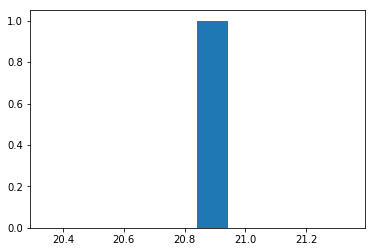

In [111]:
plt.hist(np.random.gamma(shape = 200, scale = 0.1))

In [112]:
def gibbs(y,x,n_iter, inital_values, hyperparameters):
    assert len(y)==len(x)
    
    # Set initial values
    beta_0 = initial_values["beta_0"]
    beta_1 = initial_values["beta_1"]
    tau = initial_values["tau"]
    
    trace = np.empty([n_iter, len(initial_values)])
    
    for i in range(n_iter):
        beta_0 = sample_beta_0(y,x,beta_1, tau, 
                               hyperparameters["mu_0"],hyperparameters["tau_0"])
        beta_1 = sample_beta_1(y,x,beta_0, tau, 
                               hyperparameters["mu_1"],hyperparameters["tau_1"])
        tau = sample_tau(y,x,beta_0, beta_1, 
                               hyperparameters["alpha"],hyperparameters["beta"])
        trace[i,:] = (beta_0, beta_1, tau)
    
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
    
    return trace
    

In [113]:
# Specify hyperparameters
hyperparameters = {
    "mu_0": 0,
    "tau_0": 1,
    "mu_1": 0,
    "tau_1": 1,
    "alpha": 2,
    "beta": 1
}

# Specify intial values 
initial_values = {
    "beta_0" : 0,
    "beta_1" : 0,
    "tau" : 2
}

In [118]:
trace = gibbs(y_train, X_train, 1000, initial_values, hyperparameters)

In [119]:
trace.iloc[-10:,:]

,beta_0,beta_1,tau
990,2.041454,1.477441,0.967763
991,2.002359,1.490812,0.992391
992,1.988382,1.511863,1.019237
993,2.045060,1.498760,0.999726
994,2.038853,1.494240,0.932608
995,2.017739,1.517555,0.957852
996,1.985492,1.484309,1.013847
997,2.019398,1.513990,1.028359
998,2.014861,1.504539,1.041177
999,2.011508,1.496593,0.886850


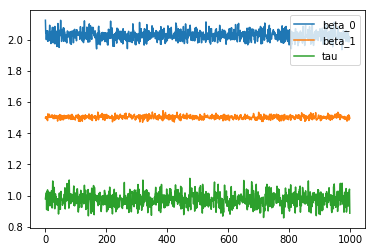

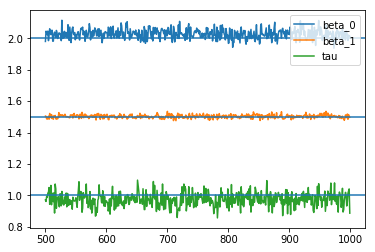

In [120]:
trace.plot()
plt.show()
trace.iloc[500:,:].plot()
plt.axhline(2)
plt.axhline(1)
plt.axhline(1.5)
plt.show()

In [122]:
print(trace[500:].median())
print(trace[500:].std())

beta_0    2.027256
beta_1    1.502388
tau       0.973706
dtype: float64
beta_0    0.030466
beta_1    0.010870
tau       0.043628
dtype: float64


## Collapsed Gibbs sampling

Resnik & Hardisty (2010): GIBBS SAMPLING FOR THE UNINITIATED